##  Moseli Motsoehli

### Seq to Seq model for comparing text similarity.

__I use the quora question pairs dataset as a test for this although the model is eventually used for text transcribed from recorded speech as a way to evaluate  public speaking__

I reuse mose of my code from a combination of a text summarization project with Jan Platos and preprocessing from a topic modelling project for ICS661. 

In [16]:
#### Libraries
import numpy as np
import scipy as sc
import pandas as pd
import logging
from collections import Counter
from  tqdm import tqdm
from tabulate import tabulate
from Generator import *

import os
import re
import nltk
from nltk.tokenize import word_tokenize as wt
from sklearn.model_selection import train_test_split as tts

import matplotlib.pyplot as plt

import keras
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras import backend as k
#k.set_learning_phase(1)
from keras import initializers
from keras.optimizers import RMSprop
from keras.models import Model,Sequential
from keras.layers import Dense,LSTM,Input,Activation,Flatten,concatenate,Reshape,Embedding,Bidirectional,Dropout
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.utils import to_categorical

#bert
#from bert_embedding import BertEmbedding as Bert

#model Freezing
#import tensorflow as tf
# freeze_graph "screenshots" the graph
#from tensorflow.python.tools import freeze_graph
# optimize_for_inference lib optimizes this frozen graph
#from tensorflow.python.tools import optimize_for_inference

## Constants

In [3]:
STRING_SIZE=15
BATCH_SIZE=32
NUM_EPOCHS = 30
EMBEDDING_SIZE=256

## Load Dataset

In [4]:
path = "C:\\Users\\Deeps\\Documents\\School\\UH manoa\\ICS 685 Virtual and Augmented Reality\\Projects\\Untitled Folder\\quora-question-pairs\\"
datafile = "train.csv"

data =  pd.read_csv(path+datafile,sep=",")[:][:2000]
print("Number of examples: %s"%len(data))
data=data.dropna(subset=['question1','question2', 'is_duplicate'])
data=data.reset_index(drop=True)
print("Number of examples after removing NA: %s"%len(data))
print("\n")
print(data.head(2))
print("\n")
print(data.tail(2))
print("\n")
print("propotion of positives: %s"%np.mean(data["is_duplicate"]))

Number of examples: 2000
Number of examples after removing NA: 2000


   id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  


        id  qid1  qid2                                          question1  \
1998  1998  3975  3976  What are some of the best tourist places to vi...   
1999  1999  3977  3978  What are the differences between a love marria...   

                                              question2  is_duplicate  
1998  Where are the foremost tourist places in Chhat...             1  
1999  Which is better: an arranged marriage or a lov...             0  


propotion of positives: 0.371


### Preprocessing addopted from my Topic Model in ICS661 AKA Thematron

In [5]:
def remove_special(text):
    special_chars = "[~#$%^@&*&()+-_\",?!.:[]\\;><`|{}=\/\'=»¿シし]"
    for k in special_chars:
            if type(text) == str:
                if k=="-" or k=="_":
                    text=text.replace(k, "")
                else:
                    text=text.replace(k, " ")       
    return text

def contractions(sent):
    sub_pattern = [("will not","won't"),("shall not","shan't"),
                (" not", "n\'t"),(" will","\'ll"),(" is","\'s"),
                   (" am","\'m"),(" are","\'re"),(" is","who\'s")]
    sent2=sent.split(" ")
    hold = ""
    for k in range(len(sent2)):
        kk = sent2[k]
        for rep in range(len(sub_pattern)):
            kk = re.sub(sub_pattern[rep][1],sub_pattern[rep][0],kk)
        hold = hold + " " + kk
    return hold.lower()

def remove_stop_words(text):
    stops =  set(stopwords.words('english'))
    stops1 = [word.lower() for word in stops]
    punctuation = [',','.','!','?',';','-']
    hold = []
    if type(text) == list:
        for word in range(len(text)):
            if text[word].lower() in stops1 or text[word].lower() in punctuation or text[word].lower() == "xxxxxx":
                continue
            else:
                hold.append(text[word].lower())
    return hold

def wordTok(sent):
    tok = wt(sent)
    return tok

def pipeline(text):
    text = contractions(text)
    text = remove_special(text)
    textToks = wordTok(text)
    #textToks = remove_stop_words(textToks)
    final = ""
    for k in range(len(textToks)):
            final = final+textToks[k]+" "
    return final.strip().lower()

########################################################
########create corpus and create word vectors and training data###########

def sequence_padding(stringlist):
    newstring = pad_sequences(stringlist, maxlen=STRING_SIZE,
                              dtype=object,padding='post',
                              truncating='post', value="PAD")
    return newstring

def list2string(listinput):
    hold=""
    for k in listinput:
        hold = hold +k.strip()+" "
    return hold.strip()

def createCorpus(t):
    "stuff"
    return all_words

In [6]:
data["question1"] = list(map(pipeline,data["question1"]))
data["question2"] = list(map(pipeline,data["question2"]))


print("Show two comparison sentences")
print("--------------------------------------------")
print("1: ",data["question1"][1])
print("--------------------------------------------")
print("2: ",data["question2"][1])
print("--------------------------------------------")
print(data["is_duplicate"][1])

Show two comparison sentences
--------------------------------------------
1:  what is the story of kohinoor kohinoor diamond
--------------------------------------------
2:  what would happen if the indian government stole the kohinoor kohinoor diamond back
--------------------------------------------
0


### Prepare to create numeric vectors

In [7]:
allWords = ""
for k in range (len(data["question1"])):
    allWords=allWords+data["question1"][k].strip().lower()+" "
    allWords=allWords+data["question2"][k].strip().lower()+" "
allcount = len(set(wt(allWords)))
print(allcount)
del allWords

6337


In [8]:
####Truncade and Pad to 20 words max
filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n»¿シし'
sent1=[one_hot(text.replace("-",""), allcount, filters=filters, lower=True, split=' ') for text in  data["question1"]]
sent2=[one_hot(text.replace("-",""), allcount, filters=filters, lower=True, split=' ') for text in  data["question2"]]

print(sent1[1])
print(sent2[1])

print(min([len(y) for y in sent2]))
print(min([len(y) for y in sent2]))

[3479, 6215, 2839, 5891, 4496, 2969, 2969, 970]
[3479, 2565, 1844, 5142, 2839, 888, 1290, 283, 2839, 2969, 2969, 970, 5582]
3
3


#### show text length distribution to decide cutoff

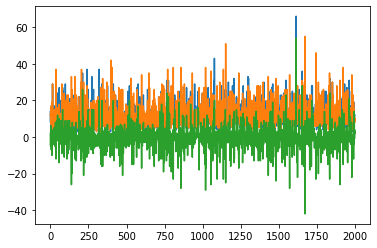

In [9]:
plt.plot([len(x) for x in sent1])
plt.plot([len(y) for y in sent2])
plt.plot([len(sent1[x])-len(sent2[x]) for x in range(len(sent1))])

In [10]:
sent1pad = pad_sequences(sent1, maxlen=STRING_SIZE,padding='post',truncating='post')
sent2pad = pad_sequences(sent2,maxlen=STRING_SIZE,padding='post',truncating='post')

__After padding__

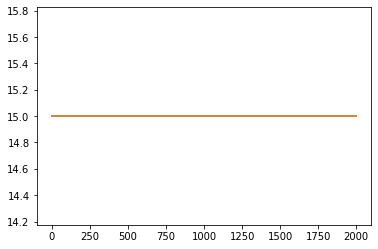

In [11]:
plt.plot([len(x) for x in sent1pad])
plt.plot([len(y) for y in sent2pad])

In [12]:
split=int(0.8*len(sent1pad))
#x_train,x_test,y_train,y_test = tts(sentall,y,test_size=0.2)
#x_train,x_val,y_train,y_val = tts(x_train,y_train,test_size=0.1)
y = to_categorical(data["is_duplicate"])
x1_train = sent1pad[:split]
x1_val = sent2pad[split:]
x2_train = sent2pad[:split]
x2_val = sent1pad[split:]
y_train = y[:split]
y_val = y[split:]

x1_train = np.asarray(x1_train,dtype='float32')
x1_val = np.asarray(x1_val,dtype='float32')
x2_train = np.asarray(x2_train,dtype='float32')
x2_val = np.asarray(x2_val,dtype='float32')
y_train = np.asarray(y_train,dtype='float32')
y_val = np.asarray(y_val,dtype='float32')

TRAIN_SIZE = len(x1_train)
VAL_SIZE = len(x1_val)

### Instantiate the 2 generatores

In [13]:
print(x1_train.shape)
print(y_train.shape)
gentrain = get_samples_2_inputs(x1_train,x2_train,y_train,BATCH_SIZE)
gentest = get_samples_2_inputs(x1_val,x2_val,y_val,BATCH_SIZE)

(1600, 15)
(1600, 2)


Results of the embedding are returned as a list of sentences and their token embeddings, so each sentence is of the form<br>
__(sentence,embeddings for each word)__

In [14]:
del sent1pad
del sent2pad
del data
del sent1
del sent2

### Now Build an LSTM model with 2 inputs and one output

In [21]:
model1_input = Input(shape=(x1_train.shape[1],),name="input1")
model1_embedding = Embedding(allcount,output_dim=EMBEDDING_SIZE,input_length=STRING_SIZE,name="embedding1")(model1_input)
model1_LSTM = LSTM(256,return_sequences=False,activation='relu',dropout=0.4,name="LSTM1")(model1_embedding)
model1 = Model(model1_input,model1_LSTM)

model2_input = Input(shape=(x2_train.shape[1],),name='input2')
model2_embedding = Embedding(allcount,output_dim=EMBEDDING_SIZE,input_length=STRING_SIZE,name="embedding2")(model2_input)
model2_LSTM = LSTM(256,return_sequences=False,activation='relu',dropout=0.4,name="LSTM2")(model2_embedding)
model2 = Model(model2_input,model2_LSTM)

merged = concatenate([model1_LSTM,model2_LSTM],name="merge")
#model_merged_LSTM = LSTM(512,return_sequences=False,activation='relu',dropout=0.4,name="LSTM_merge")(merged)
model_merged_LSTM = Dense(512,activation="relu",name="LSTM_merge")(merged)
model_merged_out = Dense(2,activation="softmax",name="output")(model_merged_LSTM)
model=Model([model1_input,model2_input],model_merged_out)

model.compile("adam", loss ='categorical_crossentropy', metrics=['accuracy'])
model.fit([x1_train[:100],x2_train[:100]], y_train[:100],
          epochs=1,
          verbose=2,
          batch_size=4,
          validation_split=0.2)
model.summary()

Train on 80 samples, validate on 20 samples
Epoch 1/1
 - 4s - loss: 0.6682 - accuracy: 0.5750 - val_loss: 0.6612 - val_accuracy: 0.6500
Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             (None, 15)           0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             (None, 15)           0                                            
__________________________________________________________________________________________________
embedding1 (Embedding)          (None, 15, 256)      1622272     input1[0][0]                     
__________________________________________________________________________________________________
embedding2 (Embedding)          (None, 15, 256)      1

In [22]:
model.fit_generator(gentrain, 
                     steps_per_epoch=TRAIN_SIZE//BATCH_SIZE,
                     verbose=2,
                     validation_data=gentest,
                     validation_steps=VAL_SIZE//BATCH_SIZE,
                     validation_freq=[5,10,20,NUM_EPOCHS],
                     epochs=NUM_EPOCHS,
                     workers=3,
                     use_multiprocessing=False)
model.save('my_model.h5')

Epoch 1/30
 - 6s - loss: 0.6413 - accuracy: 0.6206
Epoch 2/30
 - 6s - loss: 0.5409 - accuracy: 0.7163
Epoch 3/30
 - 6s - loss: 0.3506 - accuracy: 0.8462
Epoch 4/30
 - 7s - loss: 0.2553 - accuracy: 0.9119
Epoch 5/30
 - 6s - loss: 0.1763 - accuracy: 0.9331 - val_loss: 0.8041 - val_accuracy: 0.6562
Epoch 6/30
 - 6s - loss: 0.0866 - accuracy: 0.9675 - val_loss: 0.8041 - val_accuracy: 0.6562
Epoch 7/30
 - 6s - loss: 0.3696 - accuracy: 0.9731 - val_loss: 0.8041 - val_accuracy: 0.6562
Epoch 8/30
 - 6s - loss: 0.0541 - accuracy: 0.9856 - val_loss: 0.8041 - val_accuracy: 0.6562
Epoch 9/30
 - 6s - loss: 0.0882 - accuracy: 0.9800 - val_loss: 0.8041 - val_accuracy: 0.6562
Epoch 10/30
 - 6s - loss: 0.0382 - accuracy: 0.9850 - val_loss: 2.3875 - val_accuracy: 0.5521
Epoch 11/30
 - 6s - loss: 0.0319 - accuracy: 0.9912 - val_loss: 2.3875 - val_accuracy: 0.5521
Epoch 12/30
 - 6s - loss: 0.0601 - accuracy: 0.9875 - val_loss: 2.3875 - val_accuracy: 0.5521
Epoch 13/30
 - 6s - loss: 0.0274 - accuracy: 0.99

In [23]:
model.evaluate([x1_val,x2_val],y_val,
              batch_size=BATCH_SIZE)

400/400 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 0s 1ms/step


[25.823695755004884, 0.5625]